In [ ]:
%cd ../..
%load_ext autoreload

%autoreload 2

In [137]:
import os
import json
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from rts.features.pose import format_keypoints_to_read, keypoint_name_to_id
from rts.features.pose import KEYPOINTS_NAMES, CONNECTIONS, ANGLES_ASSOCIATIONS

import rts.features.pose as pose
import umap
import cv2

In [ ]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


# Load poses

## From jsonlines files

In [121]:
poses_folder = "data/test_poses/"
poses_jl = [poses_folder + f for f in os.listdir(poses_folder)]
poses = []
for pose_json in poses_jl:
    extracted_data = pose.extract_frame_data(pose_json, 0.5)
    if len(extracted_data.keys()) > 0:
        pose_exp = [[{"frame_number":k, "angle_vec":angle, "keypoints":keypoint, "bbox":bbox} for angle,keypoint,bbox in zip(v["angle_vec"], v["keypoints"], v["bbox"])] for k,v in extracted_data.items()]
        pose_exp = [item for sublist in pose_exp for item in sublist]
        [p.update({"video_name":pose_json.split("/")[-1].split(".")[0]}) for p in pose_exp]
        poses.extend(pose_exp)

print(len(poses))

14311


# Visualize poses

In [ ]:
sequences_folder = "/mnt/g/ioc/sequences/"

def get_frame(video_name, frame_number):
    video_path = [f for f in os.listdir(sequences_folder + video_name) if f.endswith(".mp4")][0]
    cap = cv2.VideoCapture(sequences_folder + video_name + "/" + video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [124]:
def draw_pose(pose, ax = None, cut=True, threshold=0.1):
    keypoints = pose["keypoints"]

    # Do not draw non-detected keypoints
    #connections = [c for c in connections if keypoints[KEYPOINTS_NAMES.index(c[0])][2] > threshold and keypoints[KEYPOINTS_NAMES.index(c[1])][2] > threshold]
    #keypoints = [k for k in keypoints if k[2] > threshold]
    
    frame = get_frame(pose["video_name"], pose["frame_number"])

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    ax.imshow(frame)
    ax.scatter([k[0] for k in keypoints if k[2] > threshold], [k[1] for k in keypoints if k[2] > threshold], s=10)
    for c in CONNECTIONS:
        k1 = keypoints[KEYPOINTS_NAMES.index(c[0])]
        k2 = keypoints[KEYPOINTS_NAMES.index(c[1])]
        if k1[2] > threshold and k2[2] > threshold:
            ax.plot([k1[0], k2[0]], 
                    [k1[1], k2[1]], 
                    linewidth=1, color='black')
        
    # cut frame to bbox
    bbox = pose["bbox"]
    if cut:
        ax.set_xlim(int(bbox[0]),int(bbox[0] + bbox[2]))
        ax.set_ylim(int(bbox[1] + bbox[3]), int(bbox[1]))

    ax.axis("off")
    ax.set_aspect('equal')
    plt.tight_layout()

    return ax


### Plot sample of poses

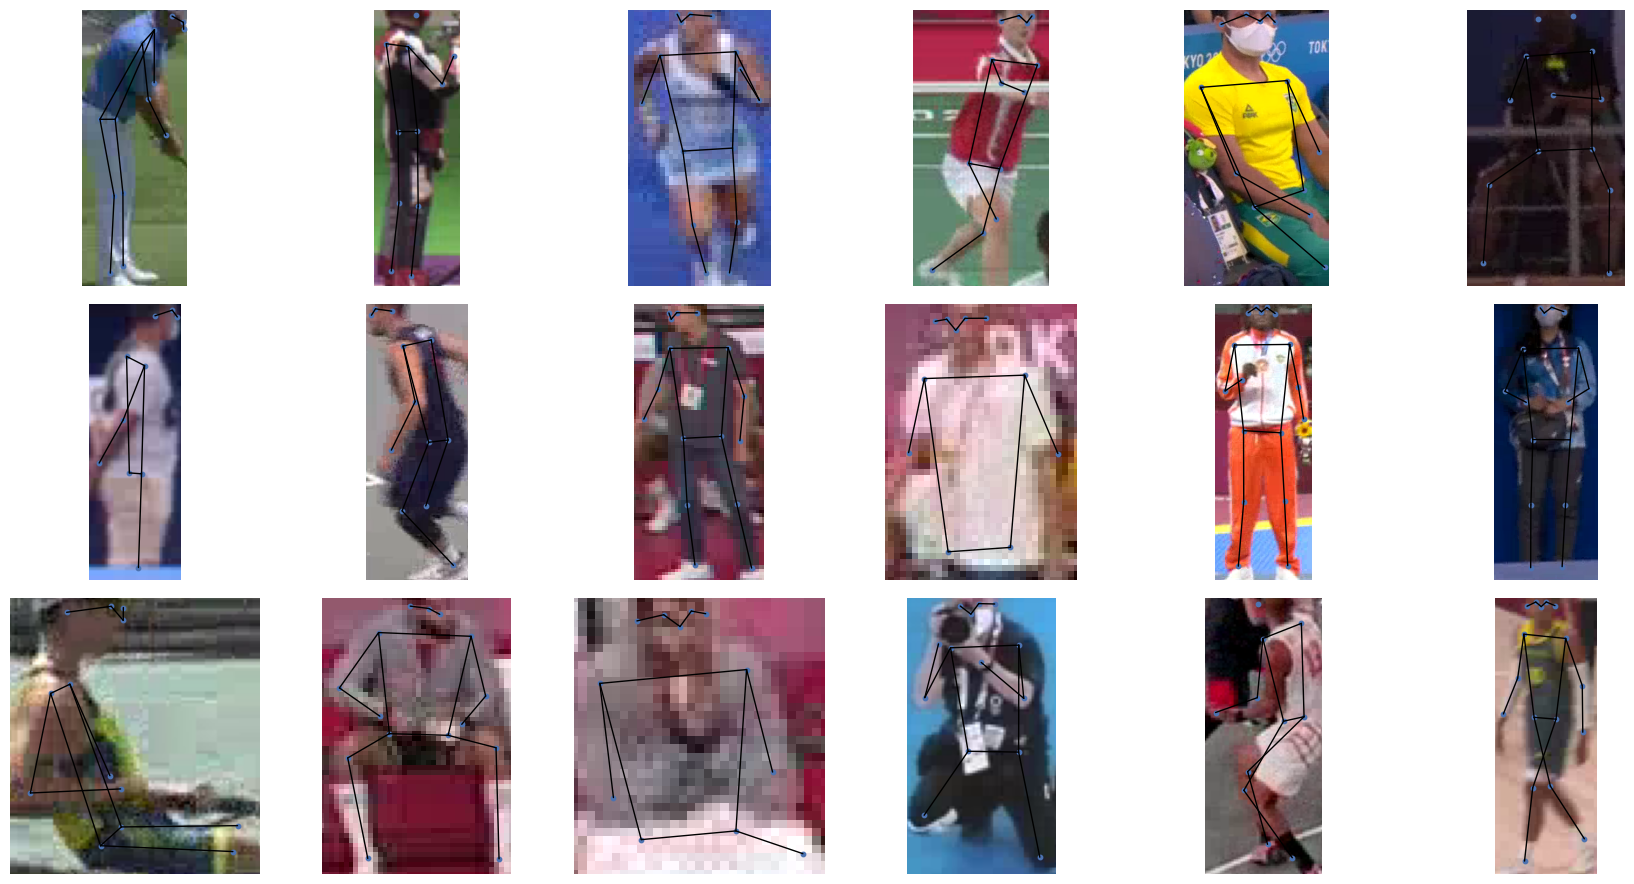

In [125]:
# create a grid of subplots
nrows = 3
ncols = 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))
axs = axs.flatten()
# iterate over the poses and draw each pose in a subplot
sample_poses = np.random.choice(poses, nrows * ncols)
for i, pose in enumerate(sample_poses):
    draw_pose(pose, ax = axs[i], cut = True)

plt.show()


### Check angles

In [138]:
def draw_angles(pose, angle_id, ax = None, cut=True, threshold=0.1):
    keypoints = pose["keypoints"]

    # Do not draw non-detected keypoints
    #connections = [c for c in connections if keypoints[KEYPOINTS_NAMES.index(c[0])][2] > threshold and keypoints[KEYPOINTS_NAMES.index(c[1])][2] > threshold]
    #keypoints = [k for k in keypoints if k[2] > threshold]
    
    frame = get_frame(pose["video_name"], pose["frame_number"])

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    ax.imshow(frame)
    ax.scatter([k[0] for k in keypoints if k[2] > threshold], [k[1] for k in keypoints if k[2] > threshold], s=10)
    for c in CONNECTIONS:
        k1 = keypoints[KEYPOINTS_NAMES.index(c[0])]
        k2 = keypoints[KEYPOINTS_NAMES.index(c[1])]
        if k1[2] > threshold and k2[2] > threshold:
            ax.plot([k1[0], k2[0]], 
                    [k1[1], k2[1]], 
                    linewidth=0.5, color='black')
        
    # Draw input angle (k1,k2,k3) on the plot as lines between the keypoints, with text showing the angle value
    angle_value = pose["angle_vec"][angle_id]
    angle_name = list(ANGLES_ASSOCIATIONS.keys())[angle_id]
    angle_keypoints = ANGLES_ASSOCIATIONS[angle_name]
    k1 = keypoints[keypoint_name_to_id(angle_keypoints[0])]
    k2 = keypoints[keypoint_name_to_id(angle_keypoints[1])]
    k3 = keypoints[keypoint_name_to_id(angle_keypoints[2])]
    if k1[2] > threshold and k2[2] > threshold and k3[2] > threshold:
        if k1[2] > threshold and k2[2] > threshold and k3[2] > threshold:
            ax.plot([k1[0], k2[0]], 
                [k1[1], k2[1]], 
                linewidth=1, color='red')
            ax.plot([k3[0], k2[0]], 
                [k3[1], k2[1]], 
                linewidth=1, color='red')
        ax.text(k2[0], k2[1], str(int(180 * angle_value)), color="black", fontsize=12)


    # cut frame to bbox
    bbox = pose["bbox"]
    if cut:
        ax.set_xlim(int(bbox[0]),int(bbox[0] + bbox[2]))
        ax.set_ylim(int(bbox[1] + bbox[3]), int(bbox[1]))
        
    ax.axis("off")
    ax.set_aspect('equal')
    ax.set_title(angle_name)
    plt.tight_layout()

    return ax

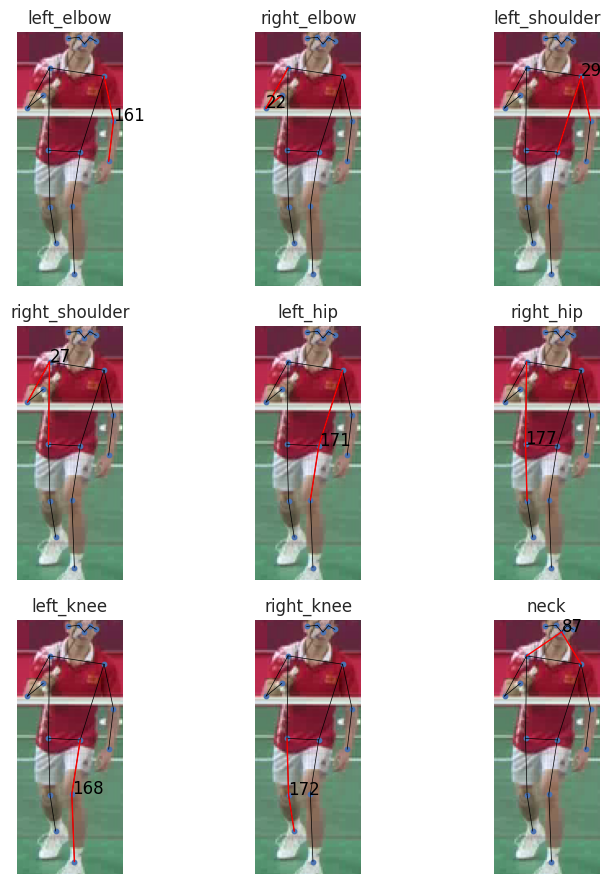

In [141]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(3 * 3, 3 * 3))
axs = axs.flatten()

for i in range(len(ANGLES_ASSOCIATIONS.keys())):
    draw_angles(poses[0], i, ax = axs[i], cut = True)
plt.show()

# Add metadata

In [142]:
from rts.utils import dataframe_from_hdf5

archiva_path = "/mnt/g/ioc/data/"
data = dataframe_from_hdf5(archiva_path, "metadata")

In [150]:
poses_df = pd.DataFrame(poses)
poses_df = pd.merge(poses_df, data[["seq_id", "sport"]], left_on="video_name", right_on="seq_id")

# Dimensionality Reduction

In [144]:
top_sports = poses_df.groupby("sport").count().sort_values("video_name", ascending=False).head(10).index.tolist()
top_sports_df = poses_df[poses_df["sport"].isin(top_sports)]
top_sports_df.shape

(11536, 7)

In [145]:
reducer = umap.UMAP(n_neighbors=1000, min_dist=0.3, metric='cosine')
embedding = reducer.fit_transform(top_sports_df["angle_vec"].tolist())
top_sports_df["umap_x"] = embedding[:,0]
top_sports_df["umap_y"] = embedding[:,1]

/tmp/ipykernel_12787/2657858174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_sports_df["umap_x"] = embedding[:,0]
/tmp/ipykernel_12787/2657858174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_sports_df["umap_y"] = embedding[:,1]


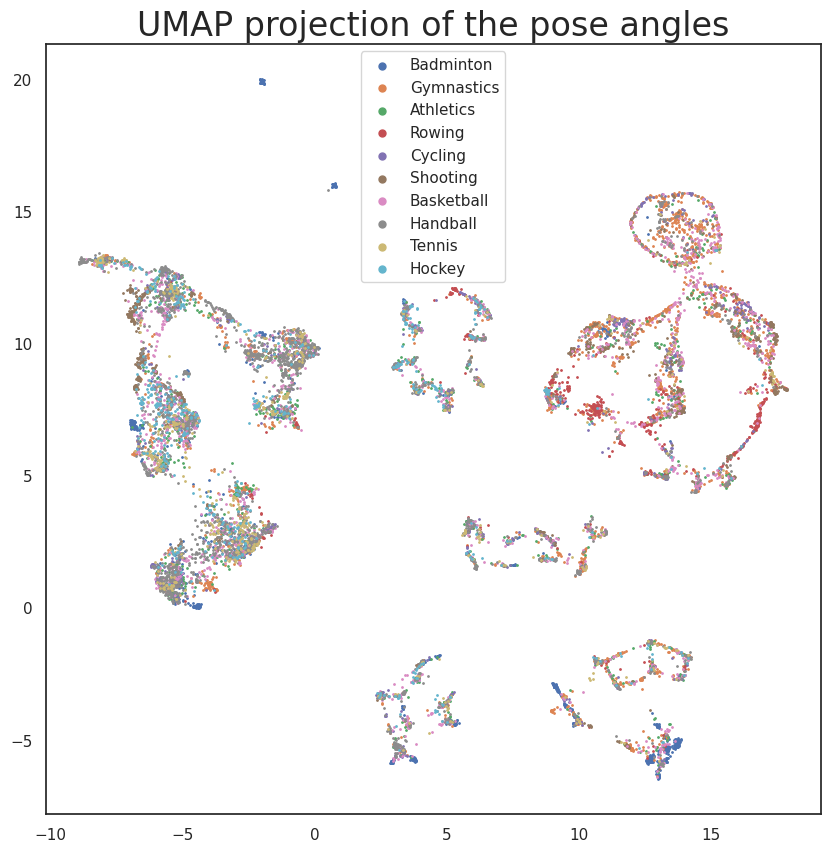

In [146]:
plt.figure(figsize=(10, 10))
for sport in top_sports_df["sport"].unique():
    plt.scatter(top_sports_df[top_sports_df["sport"] == sport]["umap_x"], 
                top_sports_df[top_sports_df["sport"] == sport]["umap_y"], 
                s= 1, label = sport)
plt.gca().set_aspect('equal', 'datalim')
plt.legend(markerscale = 5)
plt.title('UMAP projection of the pose angles', fontsize=24)
plt.show()

## Bokeh plot

In [147]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, ImageURL
from bokeh.io import push_notebook
import base64
from io import BytesIO

output_notebook()

Loading BokehJS ...

In [148]:
def image_to_base64(image_path):
    with open(image_path, "rb") as f:
        image_binary = f.read()
    return "data:image/png;base64," + base64.b64encode(image_binary).decode()

def create_annotation_image(pose):
    fig, ax = plt.subplots(figsize=(6,6))
    draw_pose(pose, ax=ax, cut=True)
    tmp_path = "data/test_images/tmp.png"
    plt.savefig(tmp_path, dpi=100, bbox_inches='tight')
    plt.close(fig)
    
    return image_to_base64(tmp_path)


In [151]:
N_POSES = 1000
EVERY_N = 5
embedded_images = [create_annotation_image(pose) for pose in poses[::EVERY_N][:N_POSES]]

In [152]:
reducer = umap.UMAP(n_neighbors=int(0.1 * N_POSES), min_dist=0.9, metric='cosine')
embedding = reducer.fit_transform([p["angle_vec"] for p in poses[::EVERY_N][:N_POSES]])

In [ ]:
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook, export_png
from PIL import Image
import io

# Example 2D points
x = embedding[:, 0]
y = embedding[:, 1]

# Create a ColumnDataSource
source = ColumnDataSource(data=dict(x=x, y=y, url=embedded_images))

# Output to notebook
output_notebook()

# Create a new plot
p = figure(width=1000, height=1000)


# Add images
p.image_url(url='url', x='x', y='y', source=source, w=0.3, h=0.3, anchor="center")

# Show the plot
handle = show(p, notebook_handle=True)
